<a href="https://colab.research.google.com/github/AayushAgrawal2003/3DModeling_PC/blob/main/GPS_Denied_Navigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPS Denied IMU Based Navigation


This notebook outlines a method to use an IMU for GPS denied navigation. We work with a MLP based network for the preciction.

Some of the preliminary research, evaluation and alternate models tested can be found in the notebooks linked below.

RNN:
https://colab.research.google.com/drive/10sKIL06LkJKDd2TPNLsaLTL8mMUXHj7Y?usp=sharing

MLP:
https://colab.research.google.com/drive/1t5SK7mA-f17oCMUP6Ap-PT8v8B784Gq0?usp=sharing

Data Exploration:
https://colab.research.google.com/drive/1ifpSCwdttXrurfHe5wlIRPrVR4r4v2iS?usp=sharing





In [ ]:
!pip install pymap3d

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.src.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
import os
from tqdm import tqdm
import pymap3d as pm
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# The local coordinate origin (First Reading)

lat0 = 19.124149  # deg
lon0 = 73.0850905	 # deg
h0 = 0 # meters
# Converting long lat to NED
def get_ned(lat, long , h):
    return pm.geodetic2enu(lat, long, h, lat0, lon0, h0)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the data from the txt file

GPS_DATA = "/content/drive/MyDrive/gps imu flight data/dec12_2023_11_29_8_42_38/day_gps.txt"
IMU_DATA = "/content/drive/MyDrive/gps imu flight data/dec12_2023_11_29_8_42_38/day_IMU.txt"
# Process the GPS data
def process_gps_data(GPS_DATA,IMU_DATA):
    # print(GPS_DATA, IMU_DATA)
    f = open(GPS_DATA, "r")
    rows = []
    final = []
    for i in f.read().split("\n"):
        # rows.append(i.split(","))
        if i == "":
            continue
        if len(final)  == 0 or final[-1][0] != i.split(",")[-5]:
                final.append([i.split(",")[-5]] + i.split(",")[:3])
    f = open(IMU_DATA, "r")
    rows = []
    for i in f.read().split("\n"):
        if i == "":
            continue
        rows.append(i.split(","))
    imu = []
    for row in rows:
        imu.append(row[1:8])

    main = []
    for i in range(len(final)):
        main.append(final[i] + imu[i])
    # print(final[1])
    return pd.DataFrame(main)

main_directory = "/content/drive/MyDrive/gps imu flight data/"
directories = [d for d in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, d))]

    # Get the absolute path of each directory
absolute_paths = [os.path.abspath(os.path.join(main_directory, d)) for d in directories]
#  process_gps_data(GPS_DATA,IMU_DATA)
holder = []
for path in absolute_paths:
    df = process_gps_data(path + "/day_gps.txt",path + "/day_IMU.txt")
    holder.append(df)
    # main = pd.concat([main,df])

# main.head()

In [ ]:
def feature(main):
    main["timestep"] = main[4]
    main = main.dropna()
    main = main.astype(float)
    main = main.reset_index()
    main[7] = main[7] + 9.8

    N,E,D = [],[],[]
    dN,dE,dD = [0],[0],[0]
    for i in range(len(main)):
      ned = get_ned(main[1][i] , main[2][i] , main[3][i])
      N.append(ned[0])
      E.append(ned[1])
      D.append(ned[2])

    deltaT = 0.02
    # V = u + at
    # main["Vx"] = main[4]
    # main["Vy"] = main[5]
    # main["Vz"] = main[6]


    # Assuming your DataFrame is named 'main' and contains columns 'angular_velocity_x', 'angular_velocity_y', 'angular_velocity_z',
    # 'acceleration_x', 'acceleration_y', and 'acceleration_z'

    # Define rotation matrix from body frame to NED frame
    R = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])

    # Extract angular velocity and acceleration columns
    angular_velocity = main[[8, 9,10]].values
    acceleration = main[[5, 6, 7]].values

    # Convert angular velocity and acceleration to NED frame
    angular_velocity_ned = np.dot(angular_velocity, R.T)
    acceleration_ned = np.dot(acceleration, R.T)

    # Add new columns to the DataFrame
    main['angular_velocity_x_ned'] = angular_velocity_ned[:, 0]
    main['angular_velocity_y_ned'] = angular_velocity_ned[:, 1]
    main['angular_velocity_z_ned'] = angular_velocity_ned[:, 2]

    main['acceleration_x_ned'] = acceleration_ned[:, 0]
    main['acceleration_y_ned'] = acceleration_ned[:, 1]
    main['acceleration_z_ned'] = acceleration_ned[:, 2]

    # Now your DataFrame 'main' contains the converted values in the NED frame


    Vx = [0]
    Vy = [0]
    Vz = [0]
    dSx = [0]
    dSy = [0]
    dSz = [0]
    x = [0]


    for i in range(1,len(main)):
        if i != len(main) - 1:
          deltaT = main[4][i+1] - main[4][i]
        # print(deltaT)
        Vx.append(Vx[-1] + (main["acceleration_x_ned"][i]*deltaT))
        Vy.append(Vy[-1] + (main["acceleration_y_ned"][i]*deltaT))
        Vz.append(Vz[-1] + (main["acceleration_z_ned"][i]*deltaT))
        dSx.append((Vx[-1] * deltaT) + (0.5* (main["acceleration_x_ned"][i]*(deltaT **2))))
        dSy.append((Vy[-1] * deltaT) + (0.5* (main["acceleration_y_ned"][i]*(deltaT **2))))
        dSz.append((Vz[-1] * deltaT) + (0.5* (main["acceleration_z_ned"][i]*(deltaT **2))))

    Vx.pop(0)
    Vx.append(0)
    Vy.pop(0)
    Vy.append(0)
    Vz.pop(0)
    Vz.append(0)

    dSx.pop(0)
    dSx.append(0)
    dSy.pop(0)
    dSy.append(0)
    dSz.pop(0)
    dSz.append(0)
    main["deltaS_x"] = pd.Series(dSx)
    main["deltaS_y"] = pd.Series(dSy)
    main["deltaS_z"] = pd.Series(dSz)

    main["V_x"] = pd.Series(Vx)
    main["V_y"] = pd.Series(Vy)
    main["V_z"] = pd.Series(Vz)


    from scipy.signal import savgol_filter


    main["N"] = pd.Series(N)
    main["E"] = pd.Series(E)
    main["D"] = pd.Series(D)

    # Choose window size and polynomial order (adjust as needed)
    window_length = 150
    poly_order = 3

    # Create a new argument dictionary for savgol_filter
    filter_args = {'window_length': window_length, 'polyorder': poly_order}

    # Smooth the data using savgol_filter with the argument dictionary
    smoothed_n = savgol_filter(main['N'], **filter_args)
    smoothed_e = savgol_filter(main['E'], **filter_args)
    smoothed_d = savgol_filter(main['D'], **filter_args)


    main["N_smooth"] = pd.Series(smoothed_n)
    main["E_smooth"] = pd.Series(smoothed_e)
    main["D_smooth"] = pd.Series(smoothed_d)

    # Calcualte the Delta NED Values
    for i in range(1,len(main)):
      dN.append(smoothed_n[i] - smoothed_n[i-1])
      dE.append(smoothed_e[i] - smoothed_e[i-1])
      dD.append(smoothed_d[i] - smoothed_d[i-1])

    main["dN"] = pd.Series(dN)
    main["dE"] = pd.Series(dE)
    main["dD"] = pd.Series(dD)

    # Assuming main is your DataFrame
    columns_to_normalize = [10, 5, 6, 7, 8, 9, "dN", "dE", "dD",'deltaS_x','deltaS_y','deltaS_z','V_x','V_y','V_z',1,2,3]

    # Select the columns to normalize
    columns_to_normalize = [str(col) for col in columns_to_normalize]
    columns_to_normalize = list(filter(lambda col: col in main.columns, columns_to_normalize))

    # Create a MinMaxScaler
    scaler = MinMaxScaler()

    # Normalize the selected columns
    main[columns_to_normalize] = scaler.fit_transform(main[columns_to_normalize])

    return main

In [ ]:
main = pd.DataFrame()
for i in holder:
  df = feature(i)
  df = df[100:-100]
  main = pd.concat([main,df])


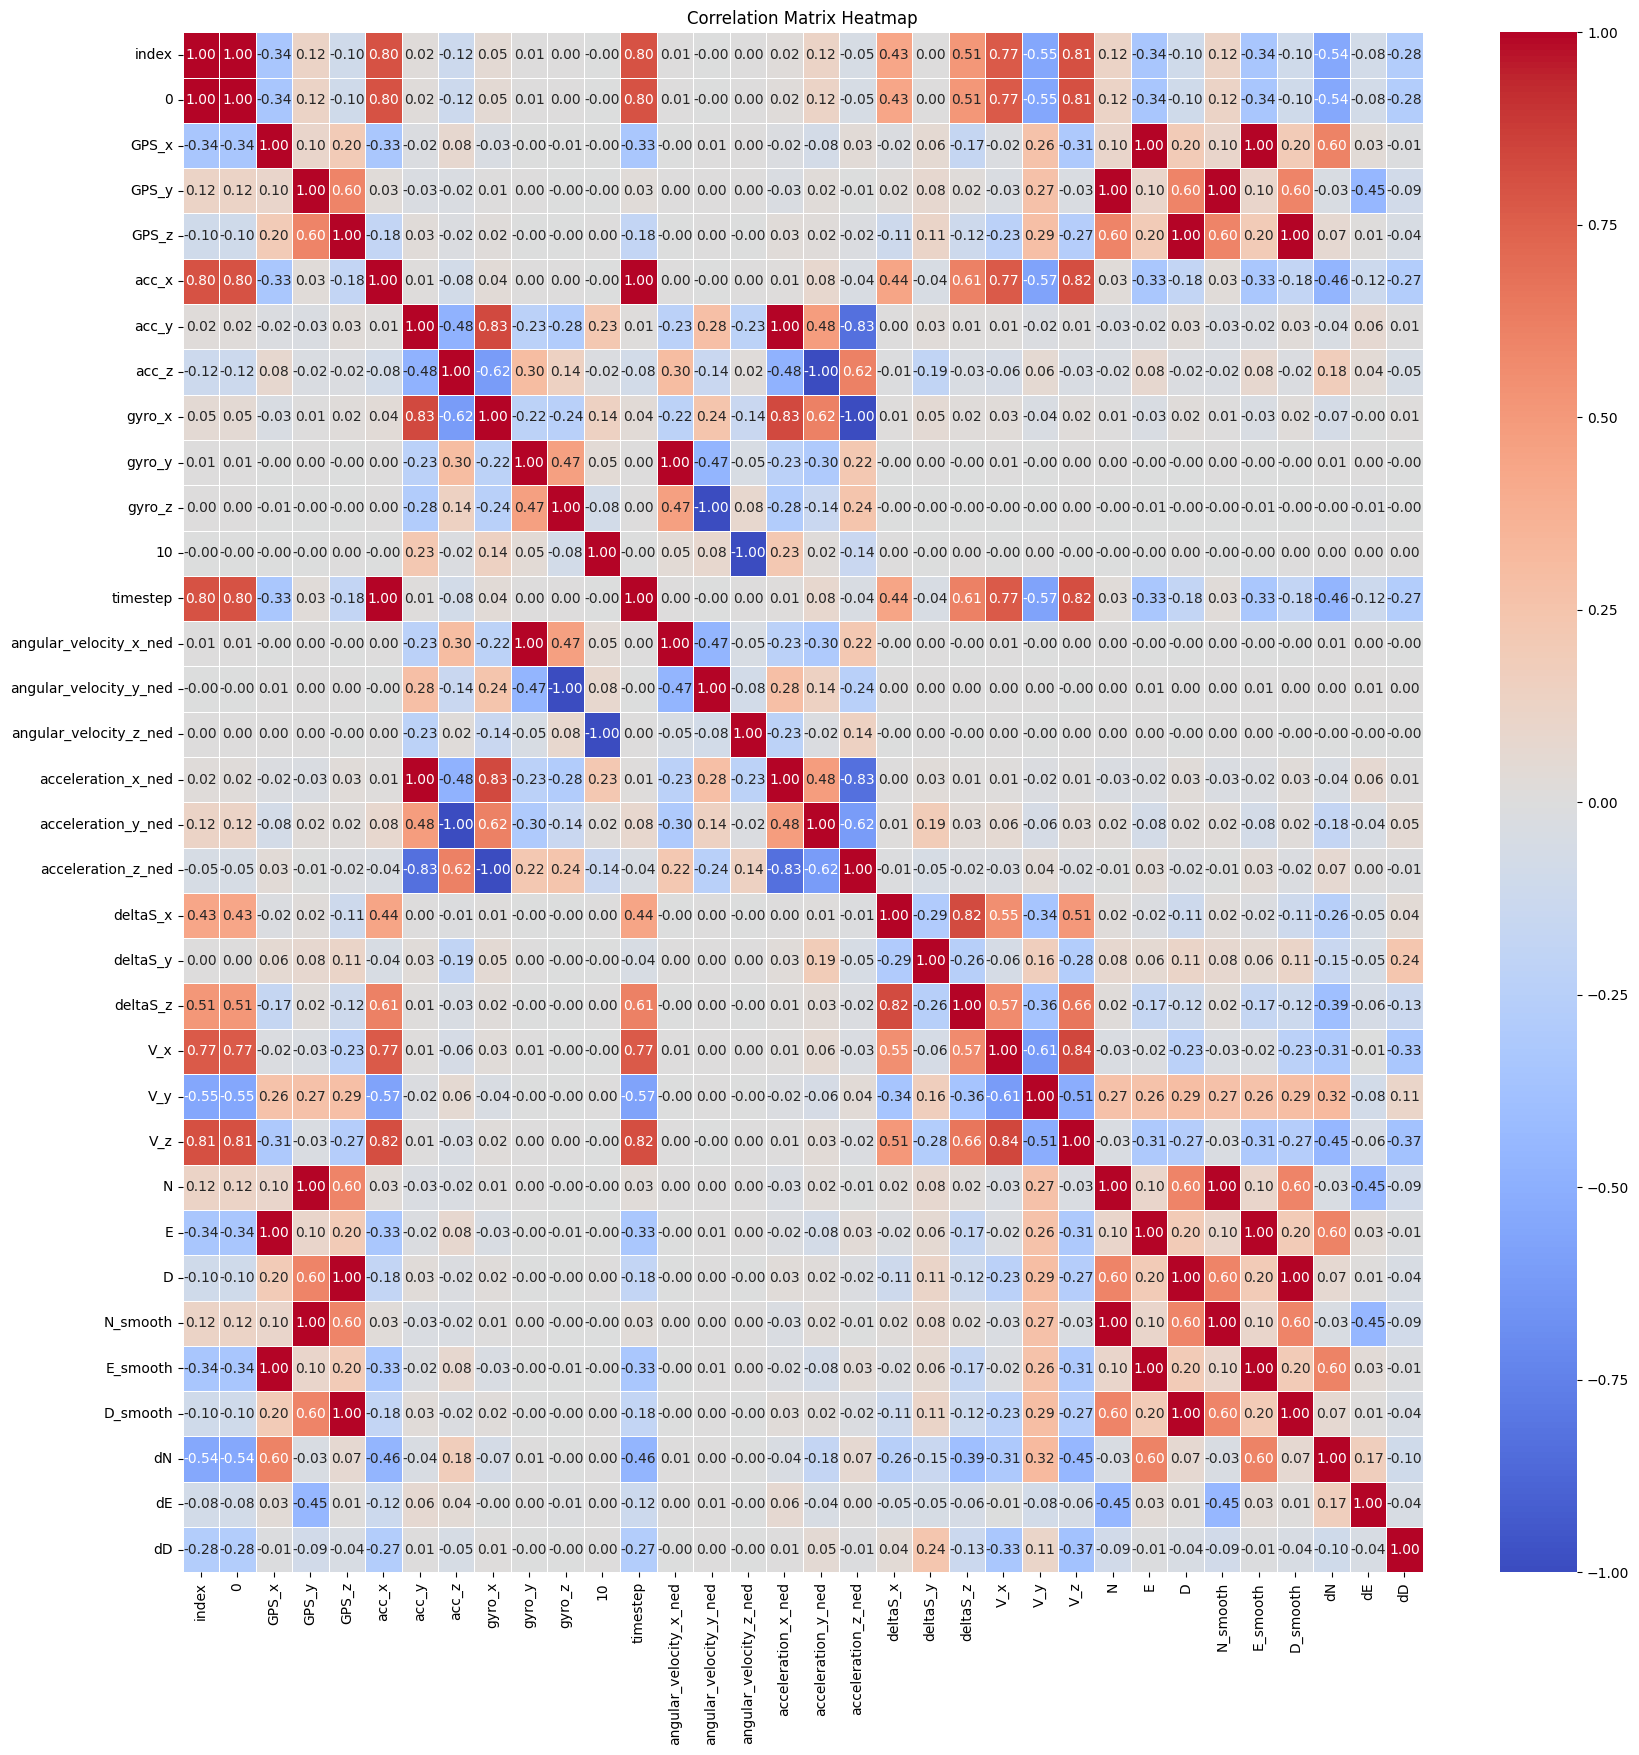

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



corr_matrix = main.rename(columns={1:'GPS_x',2:'GPS_y',3:'GPS_z',4: 'acc_x', 5: 'acc_y', 6: 'acc_z',7: 'gyro_x', 8: 'gyro_y', 9: 'gyro_z'})
correlation_matrix = corr_matrix.corr()

plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.savefig("corr.png")

plt.show()



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError  # For regression tasks
from tensorflow.keras.callbacks import EarlyStopping

# Create an EarlyStopping callback

# Load your pandas DataFrame here (replace with your actual data)

# Specify input and output columns

input_cols = ['deltaS_x','deltaS_y','deltaS_z','V_x','V_y','V_z']
output_cols = ["dN","dE","dD"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(main[input_cols], main[output_cols],
                                                test_size=0.1, random_state=42)  # Adjust test_size as needed


channel_weights = [1.782662178179543,1.7493042646808263,2.114297108609691]  # Adjust these weights based on your specific requirements
# Define a custom loss function that applies channel-wise weights
def custom_weighted_loss(y_true, y_pred):
    squared_errors = tf.square(y_true - y_pred)
    weighted_errors = squared_errors * channel_weights
    return tf.reduce_mean(weighted_errors)

# Build the Dense neural network
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(len(input_cols),)))  # Adjust hidden layer size as needed
model.add(Dense(128, activation='relu'))  # Adjust hidden layer size as needed
model.add(Dense(64, activation='relu'))  # Adjust hidden layer size as needed
model.add(Dense(len(output_cols)))  # Output layer for multiple outputs

# Compile the model
early_stopping = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

model.compile(loss=custom_weighted_loss, optimizer=Adam(), metrics=['mae'])  # Choose metrics suitable for your task

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[early_stopping])  # Adjust epochs as needed)  # Adjust epochs as needed

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

# # Make predictions on new data
# new_data = {'col1': 10, 'col2': 20, 'col3': 30}  # Replace with your new data
# predictions = model.predict(pd.DataFrame([new_data]))
# print(f"Predictions: {predictions[0]}")


Epoch 1/100
5430/5430 [==============================] - 16s 3ms/step - loss: 0.0309 - mae: 0.0928 - val_loss: 0.0236 - val_mae: 0.0811
Epoch 2/100
5430/5430 [==============================] - 16s 3ms/step - loss: 0.0210 - mae: 0.0763 - val_loss: 0.0190 - val_mae: 0.0726
Epoch 3/100
5430/5430 [==============================] - 13s 2ms/step - loss: 0.0183 - mae: 0.0708 - val_loss: 0.0167 - val_mae: 0.0676
Epoch 4/100
5430/5430 [==============================] - 14s 3ms/step - loss: 0.0167 - mae: 0.0675 - val_loss: 0.0162 - val_mae: 0.0657
Epoch 5/100
5430/5430 [==============================] - 17s 3ms/step - loss: 0.0155 - mae: 0.0648 - val_loss: 0.0148 - val_mae: 0.0629
Epoch 6/100
5430/5430 [==============================] - 14s 3ms/step - loss: 0.0147 - mae: 0.0631 - val_loss: 0.0136 - val_mae: 0.0613
Epoch 7/100
5430/5430 [==============================] - 15s 3ms/step - loss: 0.0140 - mae: 0.0615 - val_loss: 0.0147 - val_mae: 0.0638
Epoch 8/100
5430/5430 [=========================

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


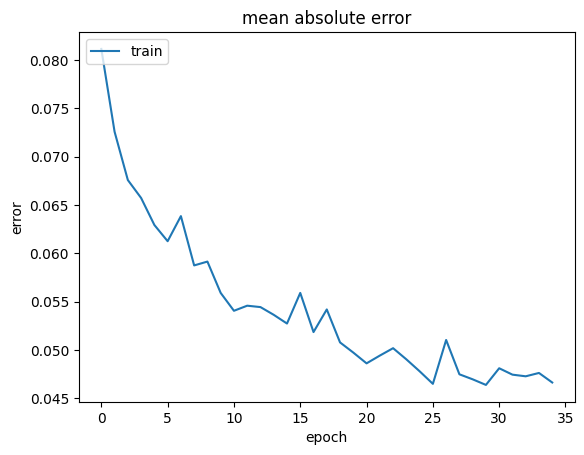

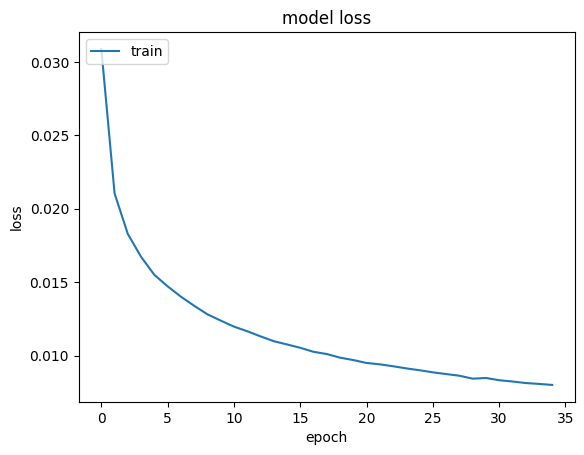

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_mae'])
# plt.plot(history.history['val_accuracy'])
plt.title('mean absolute error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("error.png")
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("loss.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Select a sample of validation data (adjust as needed)
sample_size = 100000
y_input = main[input_cols]
y_true = main[output_cols]
X_sample = y_input.iloc[:sample_size]  # Select only specified input columns
y_sample = y_true.iloc[:sample_size]  # Select only specified output columns

# Make predictions on the sample data


# input_cols = [4,5,6,7,8,9,"N_prev","E_prev","D_prev",]
# output_cols = ["N","E","D"]
# predictions = []
# next_X = np.array([np.array(X_sample)[0]])
# for i in range(len(X_sample)):
temp_predictions = model.predict(X_sample,verbose = 0)
predictions = temp_predictions


predictions = np.array(predictions)
# predictions
# # Create the plots
# for i, output_col in enumerate(output_cols):
#     plt.figure(figsize=(8, 6))
#     plt.plot(range(len(y_sample)), y_sample[output_col], label='Actual ' + output_col)
#     plt.plot(range(len(y_sample)), predictions[:, i], label='Predicted ' + output_col, linestyle="dashed")
#     plt.xlabel('Sample Index')
#     plt.ylabel(output_col)
#     plt.title('Predictions vs. Actual Values for ' + output_col)
#     plt.legend()
#     plt.grid(True)
#     plt.savefig(output_col)
#     plt.show()

In [ ]:
print(1/(main["dN"].abs().sum()/len(main)))
print(1/(main["dE"].abs().sum()/len(main)))
print(1/(main["dD"].abs().sum()/len(main)))

1.782662178179543
1.7493042646808263
2.114297108609691


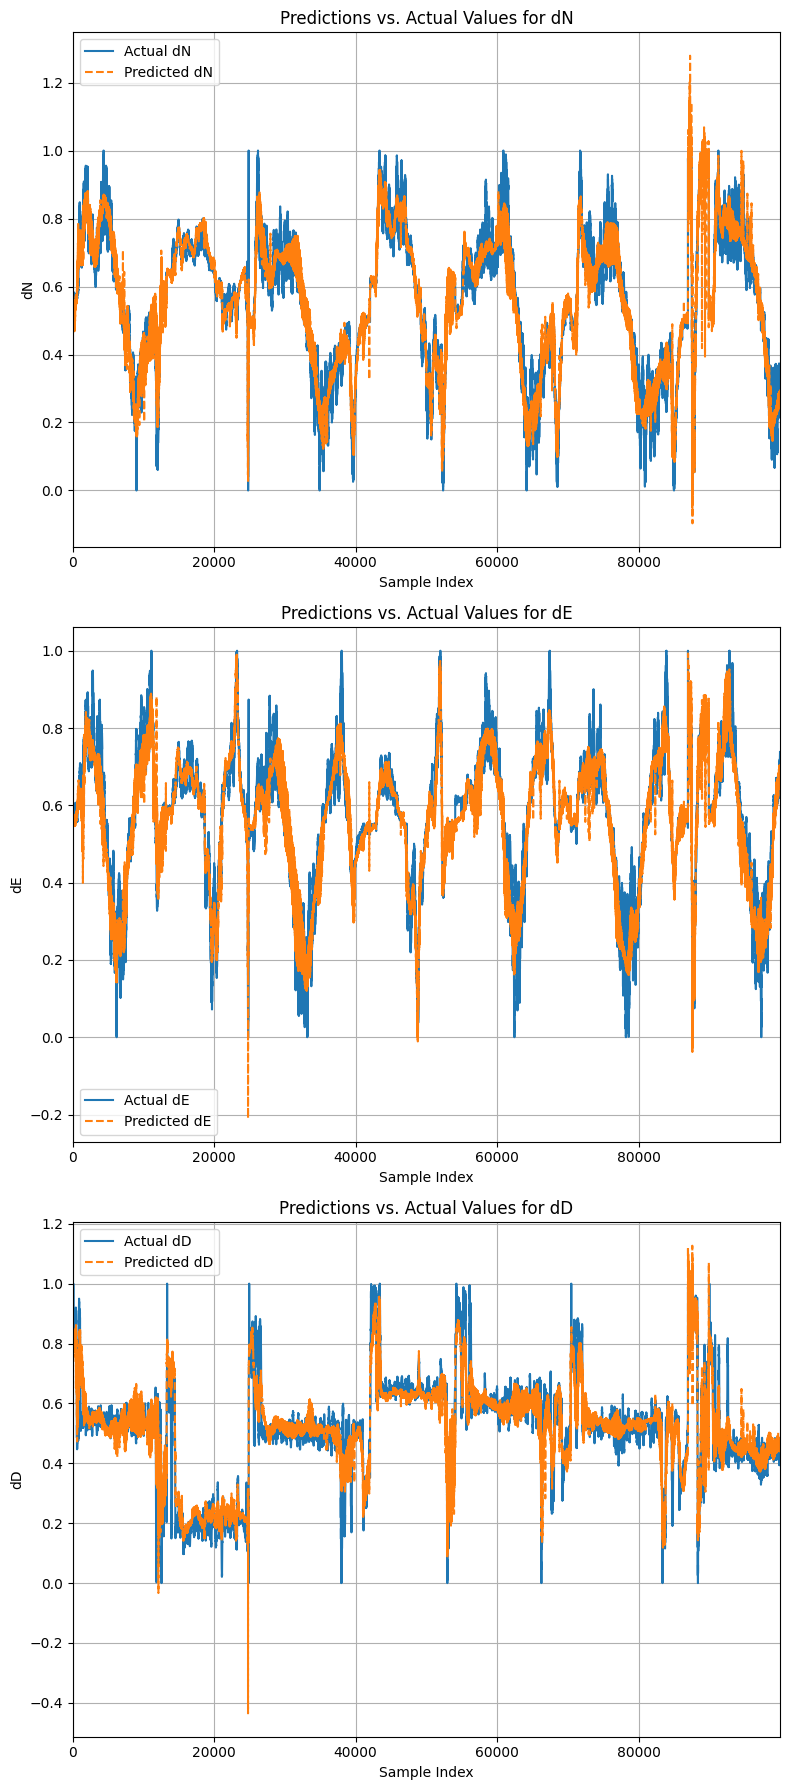

In [ ]:
fig, axs = plt.subplots(len(output_cols), figsize=(8, 6*len(output_cols)))

for i, output_col in enumerate(output_cols):
    axs[i].plot(range(len(y_sample)), y_sample[output_col], label='Actual ' + output_col)
    axs[i].plot(range(len(y_sample)), predictions[:, i], label='Predicted ' + output_col, linestyle="dashed")
    axs[i].set_xlabel('Sample Index')
    axs[i].set_ylabel(output_col)
    axs[i].set_title('Predictions vs. Actual Values for ' + output_col)
    axs[i].legend()
    axs[i].grid(True)
    axs[i].autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.savefig("final")
plt.show()